In [1]:
!pip install -q efficientnet

In [2]:
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import os
import shutil
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as L
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
# Configuration
EPOCHS = 40
BATCH_SIZE = 16
GCS_DS_PATH = '/content/drive/My Drive/Colab Notebooks/AIMango_sample/C1-P1-lite-2.npz'

if not os.path.os.path.exists('C1-P1-lite-2.npz'):
    shutil.copyfile(GCS_DS_PATH, 'C1-P1-lite-2.npz')
npz_file = np.load('C1-P1-lite-2.npz') # 資料路徑

In [4]:
 SPLIT_VALIDATION = True
 
 train_paths, valid_paths, train_labels, valid_labels = npz_file['x_train'], npz_file['x_test'], npz_file['y_train'], npz_file['y_test']

In [ ]:
# from tensorflow.keras.utils import to_categorical

# train_labels = to_categorical(train_labels, num_classes=3)
# valid_labels = to_categorical(valid_labels, num_classes=3)

In [5]:
image_size = 224

In [6]:
def decode_image(image, label=None, image_size=(image_size, image_size)):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)

    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [7]:
AUTO = 3

In [8]:
train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
train_dataset_1 = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

# test_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices(test_paths)
#     .map(decode_image, num_parallel_calls=AUTO)
#     .map(data_augment, num_parallel_calls=AUTO)
#     .batch(BATCH_SIZE)
# )

Learning rate schedule: 0.0001 to 0.0001 to 9.99e-05


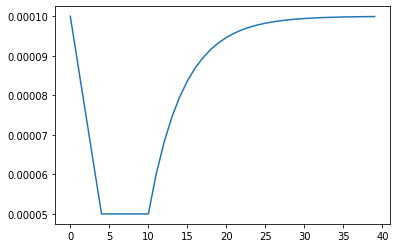

In [9]:
LR_START = 0.0001
LR_MAX = 0.00005
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [10]:
model = tf.keras.Sequential([
    InceptionResNetV2(
        input_shape=(image_size, image_size, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dense(3, activation='softmax')
#         SoftProbField()
])
    
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

219062272/219055592 [==============================] - 9s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_max_pooling2d (Global (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 4611      
Total params: 54,341,347
Trainable params: 54,280,803
Non-trainable params: 60,544
_________________________________________________________________


In [11]:
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE

history = model.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[lr_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset if SPLIT_VALIDATION else None,
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/40
360/360 [==============================] - 83s 230ms/step - loss: 0.7357 - sparse_categorical_accuracy: 0.6915 - val_loss: 1.4674 - val_sparse_categorical_accuracy: 0.7469 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 8.75e-05.
Epoch 2/40
360/360 [==============================] - 79s 218ms/step - loss: 0.4864 - sparse_categorical_accuracy: 0.7847 - val_loss: 0.6117 - val_sparse_categorical_accuracy: 0.7609 - lr: 8.7500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 7.500000000000001e-05.
Epoch 3/40
360/360 [==============================] - 78s 218ms/step - loss: 0.3962 - sparse_categorical_accuracy: 0.8394 - val_loss: 0.6716 - val_sparse_categorical_accuracy: 0.7734 - lr: 7.5000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 4/40
360/360 [==============================] - 79s 219ms/step - loss: 0.3188 - sparse_categori

In [12]:
model2 = tf.keras.Sequential([
    efn.EfficientNetB7(
        input_shape=(image_size, image_size, 3),
        weights='noisy-student',
        include_top=False
    ),
        L.GlobalMaxPooling2D(),
    L.Dense(3, activation='softmax')
])
    
model2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model2.summary()

258072576/258068648 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7683      
Total params: 64,105,363
Trainable params: 63,794,643
Non-trainable params: 310,720
_________________________________________________________________


In [ ]:
STEPS_PER_EPOCH = train_labels.shape[0] // 64

history = model2.fit(
    train_dataset_1, 
    epochs=EPOCHS, 
    callbacks=[lr_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset if SPLIT_VALIDATION else None,
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/40
90/90 [==============================] - 60s 668ms/step - loss: 1.5972 - sparse_categorical_accuracy: 0.3951 - val_loss: 1.1505 - val_sparse_categorical_accuracy: 0.4422 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 8.75e-05.
Epoch 2/40
90/90 [==============================] - 55s 613ms/step - loss: 1.2130 - sparse_categorical_accuracy: 0.4611 - val_loss: 0.9575 - val_sparse_categorical_accuracy: 0.5453 - lr: 8.7500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 7.500000000000001e-05.
Epoch 3/40
90/90 [==============================] - 55s 614ms/step - loss: 1.0590 - sparse_categorical_accuracy: 0.5299 - val_loss: 0.8250 - val_sparse_categorical_accuracy: 0.6250 - lr: 7.5000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 6.25e-05.
Epoch 4/40
90/90 [==============================] - 55s 610ms/step - loss: 0.9709 - sparse_categorical_accu

In [18]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10 == 1: # set up the subplots on the first call
        plt.subplots(figsize=(5, 5), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28, 1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

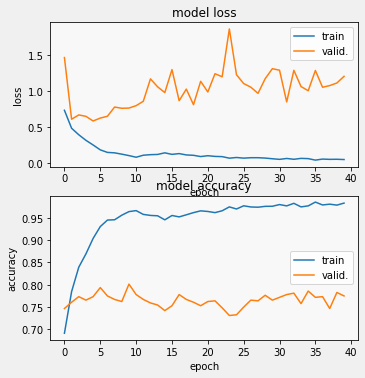

In [19]:
display_training_curves(
    history.history['loss'], 
    history.history['val_loss'], 
    'loss', 211)
display_training_curves(
    history.history['sparse_categorical_accuracy'], 
    history.history['val_sparse_categorical_accuracy'], 
    'accuracy', 212)

In [17]:
probs1 = model.predict(test_dataset, verbose=1)
probs2 = model2.predict(test_dataset, verbose=1)
probs_avg = (probs1 + probs2) / 2
probs_avg

NameError: ignored